# Choose CMIP6 best historical model

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import pickle

In [3]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())

folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

c:\Users\marti\Desktop\data\hw_extra


## Load cmip6 drivers

In [ ]:
import tensorflow as tf
import os
import numpy as np
import random
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import keras
import xarray as xr
SEED = 42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    keras.utils.set_random_seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, GRU, Conv1D, Flatten, Reshape

In [5]:
from Predictions import (
    PredictionModel,
    SERA,
)
from indices import get_heatwaves_indices, transform_time_label

c:\Users\marti\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load Data

### Drivers

In [6]:
path_drivers_ssp = "data/03_primary/drivers/dfs_dict_ssps.pickle"
with open(path_drivers_ssp, 'rb') as handle:
    cmip6_drivers_dfs = pickle.load(handle)

scenarios = list(cmip6_drivers_dfs["EC-Earth3"].keys())
cmip6_models = list(cmip6_drivers_dfs.keys())
print("Scenarios", scenarios)
print("Models", cmip6_models)

Scenarios ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
Models ['MPI-ESM1-2-HR', 'MRI-ESM2-0', 'GFDL-ESM4', 'EC-Earth3', 'MIROC6', 'AWI-CM-1-1-MR', 'INM-CM4-8', 'ensemble_mean']


In [7]:
path_drivers_historical = "data/03_primary/drivers/dfs_dict.pickle"
with open(path_drivers_historical, 'rb') as handle:
    historical_dfs = pickle.load(handle)

In [8]:
hws_chile = pd.read_csv("data/local_data/monthly/hws_chile_new_agg.csv")

hws_chile["time"] = pd.to_datetime(hws_chile["Unnamed: 0"],format='%Y-%m')
hws_chile.set_index('time', inplace=True)
hws_chile.drop(columns="Unnamed: 0", inplace=True)
# hws_chile = hws_chile[["hwn", "hwf", "hwd", "hwm", "hwa", "hwmeani"]]
hws_chile

hwn  hwf  hwd       hwm       hwa   hwmeand       hwi     hwmaxi   
time                                                                           
1971-01-01  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000   0.000000  \
1971-02-01  0.2  0.7  4.0  2.155206  4.498967  3.500000  1.508644   8.398446   
1971-03-01  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000   0.000000   
1971-04-01  0.2  0.6  3.0  3.185188  5.672930  3.000000  1.911113  13.762538   
1971-05-01  0.1  0.3  3.0  5.556710  9.012540  3.000000  1.667013  16.670130   
...         ...  ...  ...       ...       ...       ...       ...        ...   
2023-08-01  0.3  1.0  4.0  2.786501  7.586745  3.333333  2.786501  13.359577   
2023-09-01  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000   0.000000   
2023-10-01  0.1  0.3  3.0  0.627372  0.775687  3.000000  0.188212   1.882117   
2023-11-01  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000   0.000000   
2023-12-01  0.1  0.6  6.0  0.772522  1.636048  6.000000  0.463513   4.635133   

              hwmeani  
time                   
1971-01-01   0.000000  
1971-02-01   7.543220  
1971-03-01   0.000000  
1971-04-01   9.555565  
1971-05-01  16.670130  
...               ...  
2023-08-01   9.288335  
2023-09-01   0.000000  
2023-10-01   1.882117  
2023-11-01   0.000000  
2023-12-01   4.635133  

[636 rows x 9 columns]

In [9]:
era5_df = pd.concat((historical_dfs["ERA5"],hws_chile),axis=1)
era5_df

nino12    nino34  anom_wind_cl_raco  anom_wind_cl_puelche   
time                                                                      
1971-01-01 -1.928113 -1.640253           0.006237              1.624297  \
1971-02-01 -2.979414 -1.713375          -0.288501              0.221068   
1971-03-01 -3.288180 -2.059431          -0.232439              0.302271   
1971-04-01 -2.543985 -2.459558          -0.485039             -0.753484   
1971-05-01 -1.714362 -2.507134          -0.089548              0.699281   
...              ...       ...                ...                   ...   
2023-08-01  2.723302  1.550383           1.282423              1.932909   
2023-09-01  2.123090  1.722627           0.850378              1.987928   
2023-10-01  1.840521  1.741871          -0.057451             -0.161683   
2023-11-01  1.625754  1.960339           0.096582              1.173807   
2023-12-01  1.109014  2.099410          -0.348814             -1.820655   

            anom_wind_pressure  anom_ta_cl  anom_pdo  anom_psl_sam_40   
time                                                                    
1971-01-01         -155.360306    1.249381  0.997573      -112.387703  \
1971-02-01          -98.484497   -0.026722  0.767220        57.690361   
1971-03-01          -77.386848   -0.150289  0.633572         6.743707   
1971-04-01          198.601791   -0.788936  0.562198       -70.511070   
1971-05-01          185.134171    0.501217  0.420079      -178.369583   
...                        ...         ...       ...              ...   
2023-08-01         -374.929413    2.065721  1.704082       -33.429050   
2023-09-01         -178.303970    1.922226  2.295783        29.182522   
2023-10-01           24.046869   -0.402164  2.689852       312.206818   
2023-11-01         -339.330139    0.945060  2.757317       124.789513   
2023-12-01          303.737122   -1.503564  2.452650       269.578552   

            anom_psl_sam_65  anom_dmi_east  ...  adv_chile  hwn  hwf  hwd   
time                                        ...                             
1971-01-01       341.377930       0.051705  ...   5.139239  0.0  0.0  0.0  \
1971-02-01        51.769032      -0.038294  ...   0.437056  0.2  0.7  4.0   
1971-03-01      -146.034164      -0.249040  ...  -0.064510  0.0  0.0  0.0   
1971-04-01       233.869843      -0.472573  ...  -0.576733  0.2  0.6  3.0   
1971-05-01       701.905396      -0.592277  ...  -0.972252  0.1  0.3  3.0   
...                     ...            ...  ...        ...  ...  ...  ...   
2023-08-01       154.142227       0.257379  ...  -0.530017  0.3  1.0  4.0   
2023-09-01       252.867569       0.023470  ...   3.426786  0.0  0.0  0.0   
2023-10-01      -144.109970      -0.294358  ...  -1.120164  0.1  0.3  3.0   
2023-11-01        80.167175      -0.467022  ...   1.758876  0.0  0.0  0.0   
2023-12-01      -609.298462      -0.471782  ...  -0.454558  0.1  0.6  6.0   

                 hwm       hwa   hwmeand       hwi     hwmaxi    hwmeani  
time                                                                      
1971-01-01  0.000000  0.000000  0.000000  0.000000   0.000000   0.000000  
1971-02-01  2.155206  4.498967  3.500000  1.508644   8.398446   7.543220  
1971-03-01  0.000000  0.000000  0.000000  0.000000   0.000000   0.000000  
1971-04-01  3.185188  5.672930  3.000000  1.911113  13.762538   9.555565  
1971-05-01  5.556710  9.012540  3.000000  1.667013  16.670130  16.670130  
...              ...       ...       ...       ...        ...        ...  
2023-08-01  2.786501  7.586745  3.333333  2.786501  13.359577   9.288335  
2023-09-01  0.000000  0.000000  0.000000  0.000000   0.000000   0.000000  
2023-10-01  0.627372  0.775687  3.000000  0.188212   1.882117   1.882117  
2023-11-01  0.000000  0.000000  0.000000  0.000000   0.000000   0.000000  
2023-12-01  0.772522  1.636048  6.000000  0.463513   4.635133   4.635133  

[636 rows x 26 columns]

### Station Detection

In [10]:
path_stations_detection = "data/03_primary/events/cmip6/"
stat_list = [
    "330007",
    "330020",
    "330030",
    "340031",
    "360011",
    "360019",
    "380013",
    "390006",
    "400009",
    "410005",
]
hw_model_scenario_station_df = {
    model: {
        scenario: {
            station: xr.open_dataset(f"{path_stations_detection}/{model}/{scenario}/station_detection/{station}/default.nc").to_dataframe() for station in stat_list
        } for scenario in scenarios
    } for model in cmip6_models[:-1]
}

In [11]:
hws_chile_model_scenario_yearly = {}
indices = ("hwn", "hwf", "hwd", "hwm", "hwa", "hwmeand", "hwi", "hwmaxi", "hwmeani")
for model_name, dict_scenarios in hw_model_scenario_station_df.items():
    scenario_stat_hws = {}
    for scenario, dict_stations in dict_scenarios.items():
        stations_indices = {}
        if scenario == "historical":
            target_years = (1970, 2014)
        else:
            target_years = (2015, 2100)

        # Get yearly indices for 10 stations
        for station_name, hw in dict_stations.items():
            stations_indices[station_name] = get_heatwaves_indices(hw, target_years, time_scale="year")

        # Concat stations indices
        hws_all_stats = pd.concat(list(stations_indices.values()), axis=1)
        hws_chile_df = pd.DataFrame(columns=indices, index=hws_all_stats.index)

        for index in indices:
            if index in ["hwn", "hwf", "hwi"]:
                hws_chile_df[index] = hws_all_stats[index].mean(axis=1)
            elif index in ["hwd", "hwa", "hwmaxi"]:
                hws_chile_df[index] = hws_all_stats[index].max(axis=1)
            elif index == "hwmeand":
                hws_chile_df[index] = hws_all_stats["hwf"].sum(axis=1) / hws_all_stats["hwn"].sum(axis=1)
            elif index == "hwm":
                hws_chile_df[index] = hws_all_stats["hwi"].sum(axis=1) / hws_all_stats["hwf"].sum(axis=1)
            elif index == "hwmeani":
                hws_chile_df[index] = hws_all_stats["hwi"].sum(axis=1) / hws_all_stats["hwn"].sum(axis=1)

        hws_chile_df = hws_chile_df.fillna(0.0)
        scenario_stat_hws[scenario] = hws_chile_df
    hws_chile_model_scenario_yearly[model_name] = scenario_stat_hws

## Predict by full labels

In [38]:
len_pred = 1

In [ ]:
indices_of_interest = list(hws_chile.columns)
bounds = (-1.1692892810242344, -0.30647585455315646, 3.0, 6.499969486244418)
loss_fn=SERA(bounds=bounds,T=100, initial_weight=0.1, fn="piecewise2")
models_scenario_predicted = {model: {} for model in cmip6_drivers_dfs.keys()}
seasons_label_scalers = {}
df_pred_train = pd.DataFrame(columns=indices_of_interest, index=era5_df.index)
for i in range(1,13):
    df_season = era5_df[era5_df.index.month==i]
    cnn_rnn_model = Sequential([
            Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(era5_df.columns) - len(indices_of_interest))),
            Reshape((1, 16)),  # Back to time dimension
            SimpleRNN(8, activation="tanh"),
            Dropout(0.1),
            Dense(len(indices_of_interest))
        ])
    pred = PredictionModel(df_season, i, indices_of_interest, cnn_rnn_model, name_regressor="CNNRNN16",loss_fn=loss_fn)
    
    pred.compile_keras_model()
    
    y_train, y_pred_train = pred.train(len_pred)
    seasons_label_scalers[i] = pred.label_scaler
    df_pred_train.loc[df_season.index[:-len_pred]] = pred.label_scaler.inverse_transform(y_pred_train)
    df_pred_train.sort_index(inplace=True)
    for name, scenarios_df in cmip6_drivers_dfs.items():
        for scenario in scenarios:
            if i==1:
                models_scenario_predicted[name][scenario] = pd.DataFrame()
            df_target = scenarios_df[scenario][scenarios_df[scenario].index.month==i]
            if scenario == "historical":
                df_target = df_target[(df_target.index.year >=1970) & (df_target.index.year <= 2014)]
            else:
                df_target = df_target[(df_target.index.year >=2015) & (df_target.index.year <= 2100)]
            # df_target[indices_of_interest] = df_season[indices_of_interest]
            # Normalize cmip6 features for machine input
            target = pred.scaler_X.transform(df_target[pred.scaler_X.feature_names_in_])
            # Reshape for keras and predict
            predicted_normalized = pred.regressor.predict(pred.reshape_for_keras(target))
            # Transform back to original range
            predicted_real = pred.label_scaler.inverse_transform(predicted_normalized)
            predicted = pd.DataFrame(predicted_real).rename(columns={i: label for i,label in enumerate(indices_of_interest)})
            predicted["Date"] = df_target.index
            predicted.set_index("Date",inplace=True)
            models_scenario_predicted[name][scenario] = pd.concat((models_scenario_predicted[name][scenario],predicted),axis=0)

df_pred_train = df_pred_train.dropna()
df_pred_train = df_pred_train.astype(np.number)


3/3 [==============================] - 0s 2ms/step


c:\Users\marti\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\common.py:1687: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)


### Build Mean Prediction of all models

In [13]:
mean_scenario = {}
mean_std_scenario = {}
for scenario in scenarios:
    temp_df = pd.DataFrame()
    for name, model_scenario in models_scenario_predicted.items():
        temp_df = pd.concat((temp_df, model_scenario[scenario]), axis=1)
        
    mean_scenario[scenario] = pd.DataFrame(columns=models_scenario_predicted["EC-Earth3"][scenario].columns,index=model_scenario[scenario].index)
    mean_std_scenario[scenario] = pd.DataFrame(columns=models_scenario_predicted["EC-Earth3"][scenario].columns,index=model_scenario[scenario].index)

    for col in np.unique(temp_df.columns):
        mean_scenario[scenario][col] = temp_df[col].mean(axis=1)
        mean_std_scenario[scenario][col] = temp_df[col].std(axis=1)
models_scenario_predicted["mean_monthly"] = mean_scenario

## Build yearly and decadal indices

In [14]:
for scenario in scenarios:
    models_scenario_predicted["mean_monthly"][scenario] = models_scenario_predicted["mean_monthly"][scenario].astype(np.float64)

In [15]:
models_predicted_yearly = {model: {} for model in models_scenario_predicted.keys()}
models_predicted_decadal = {model: {} for model in models_scenario_predicted.keys()}

for name, model_scenario in models_scenario_predicted.items():
    for scenario, df in model_scenario.items():
        
        models_predicted_yearly[name][scenario] = transform_time_label(df, "year")
        models_predicted_decadal[name][scenario] = transform_time_label(df, "decade")


In [16]:
pred_train_yearly = transform_time_label(df_pred_train, "year")

In [17]:
mean_yearly_scenario = {}
min_yearly_scenario = {}
max_yearly_scenario = {}
mean_yearly_std_scenario = {}

features = models_predicted_yearly["EC-Earth3"][scenario].columns

for scenario in scenarios:
    temp_df = pd.DataFrame()
    for name, model_scenario in models_predicted_yearly.items():
        if "mean" not in name:
            temp_df = pd.concat((temp_df, model_scenario[scenario]), axis=1)
    
    yearly_dates = model_scenario[scenario].index
    mean_yearly_scenario[scenario] = pd.DataFrame(columns=features,index=yearly_dates)
    min_yearly_scenario[scenario] = pd.DataFrame(columns=features,index=yearly_dates)
    max_yearly_scenario[scenario] = pd.DataFrame(columns=features,index=yearly_dates)
    mean_yearly_std_scenario[scenario] = pd.DataFrame(columns=features,index=yearly_dates)
    for col in np.unique(temp_df.columns):
        mean_yearly_scenario[scenario][col] = temp_df[col].mean(axis=1)
        min_yearly_scenario[scenario][col] = temp_df[col].min(axis=1)
        max_yearly_scenario[scenario][col] = temp_df[col].max(axis=1)
        mean_yearly_std_scenario[scenario][col] = temp_df[col].std(axis=1)
models_predicted_yearly["yearly_then_mean"] = mean_yearly_scenario
models_predicted_yearly["yearly_then_min"] = min_yearly_scenario
models_predicted_yearly["yearly_then_max"] = max_yearly_scenario

## Prediction of models on historical

In [18]:
meteochile_yearly = transform_time_label(era5_df[indices_of_interest], "year")

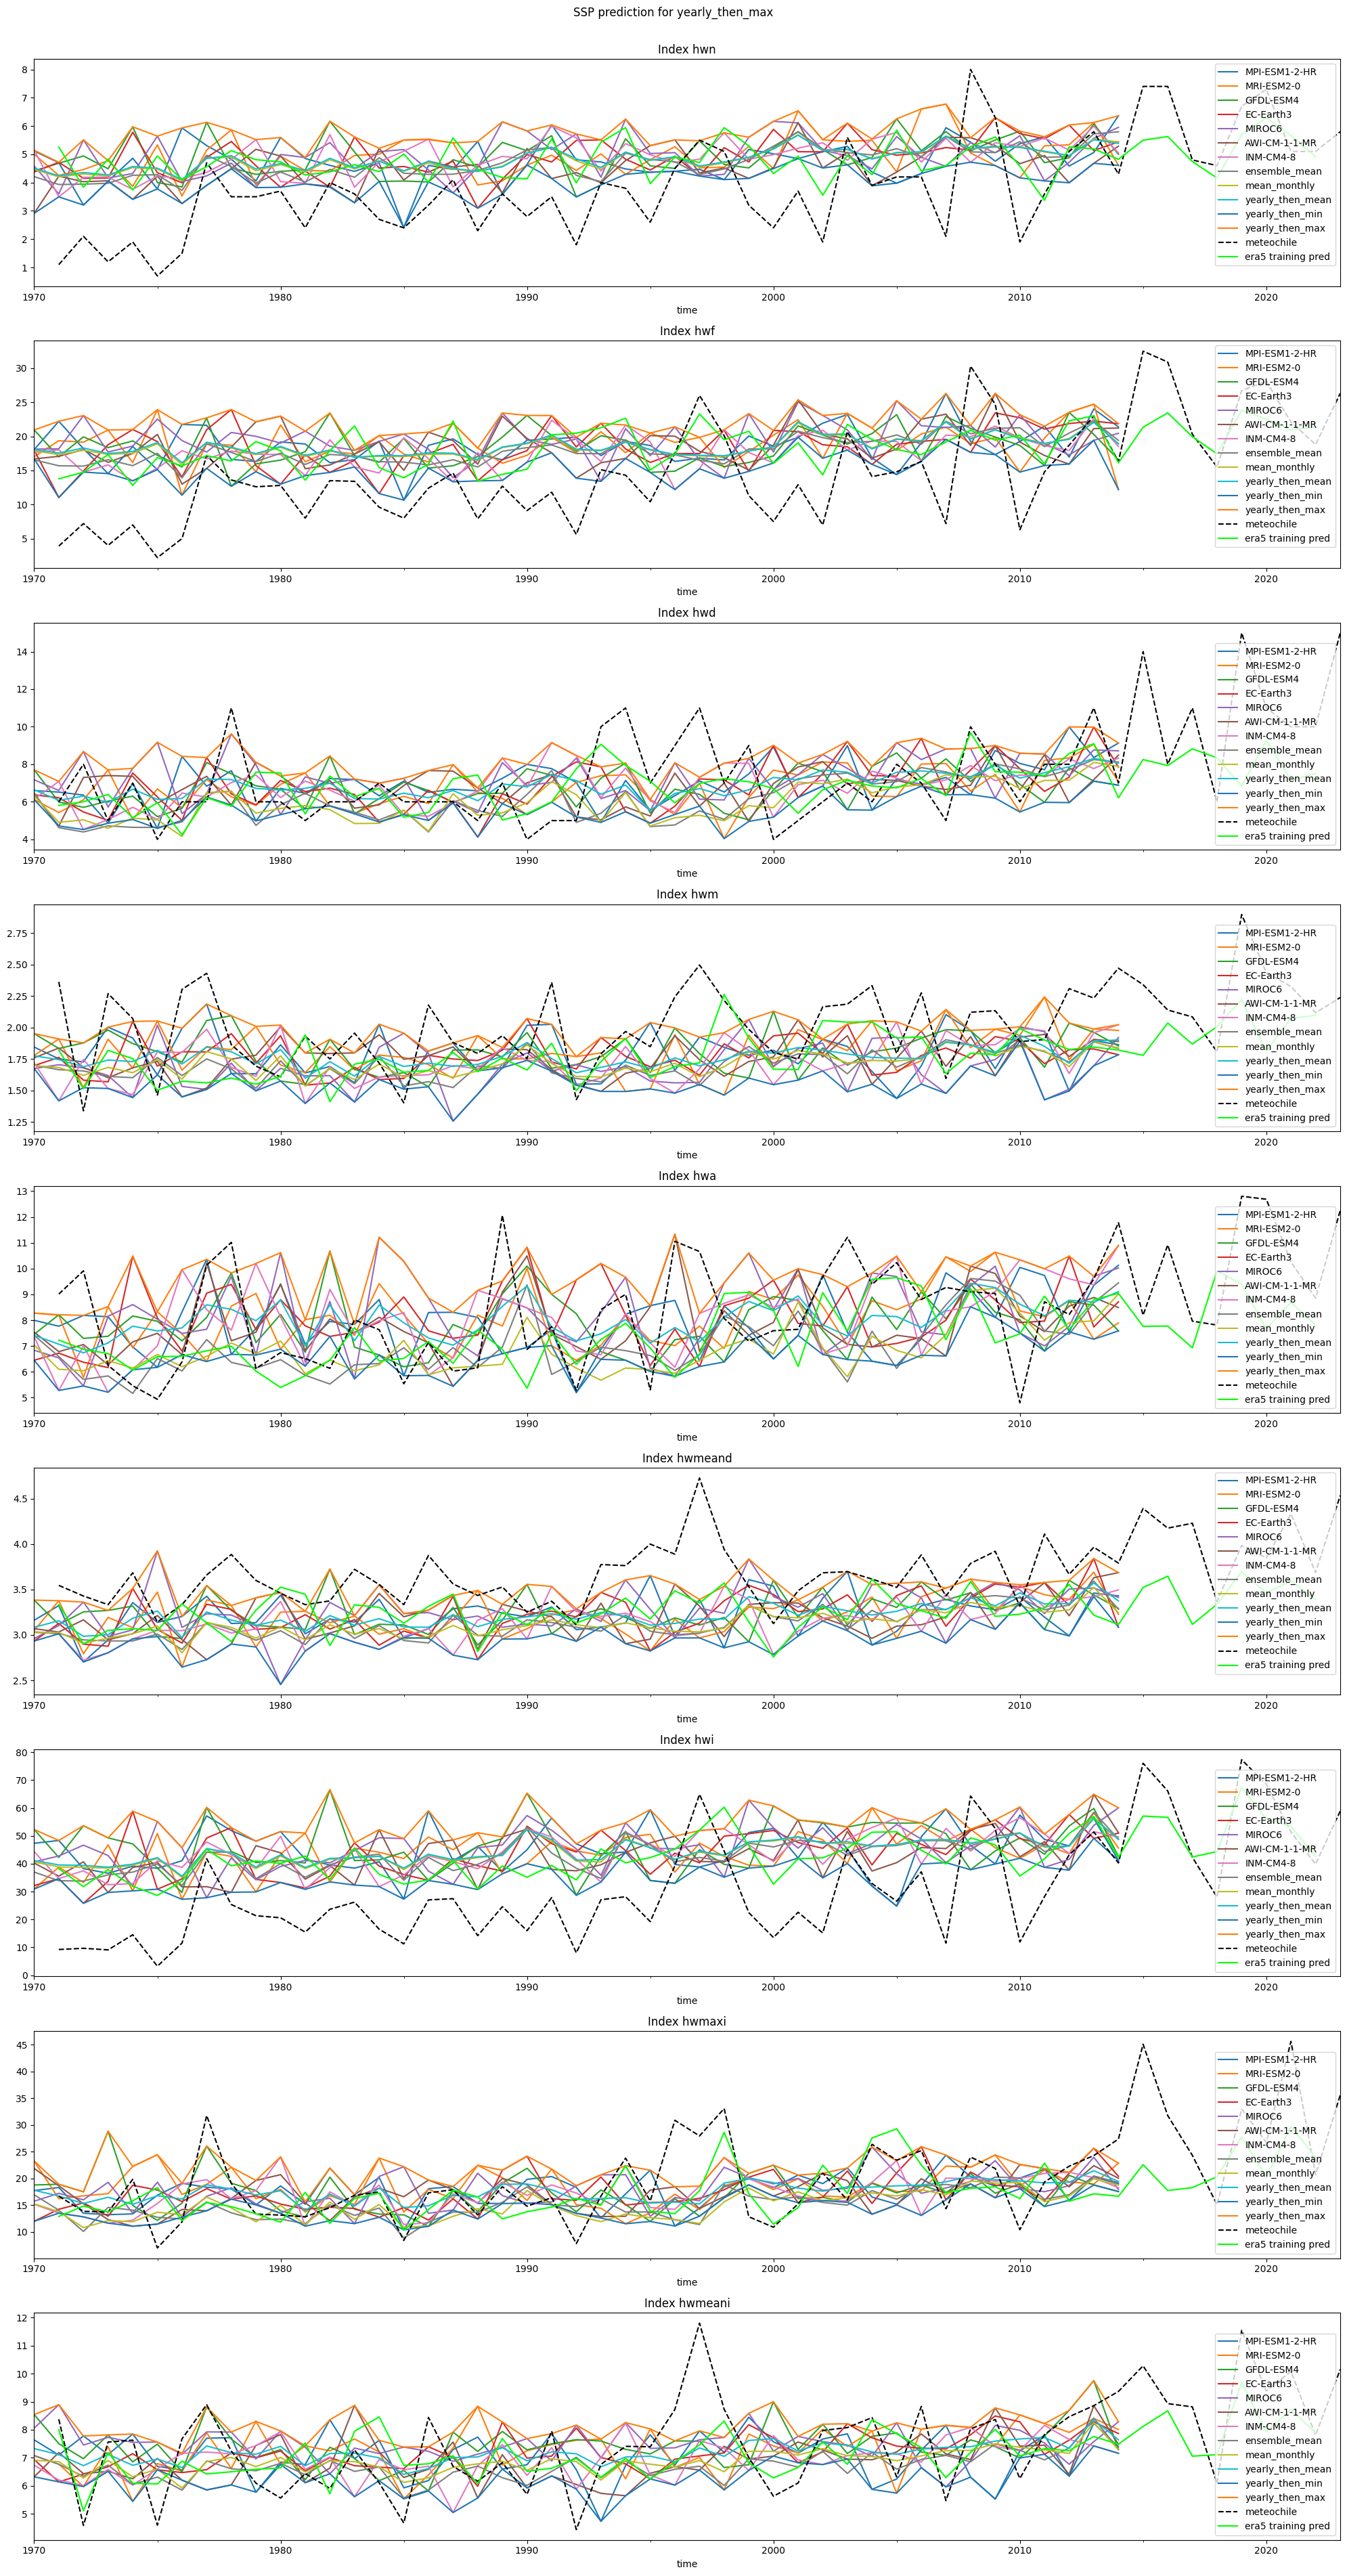

In [19]:
scenario = "historical"
fig, axs = plt.subplots(len(indices_of_interest), figsize=(20, 40))
for i, index in enumerate(indices_of_interest):
    for model, scenarios_pred in models_predicted_yearly.items():
        scenarios_pred[scenario].plot(y=index, ax=axs[i], label=model)
    meteochile_yearly.plot(y=index, linestyle="--", label="meteochile", ax=axs[i], c="black")
    pred_train_yearly.plot(y=index, label="era5 training pred", ax=axs[i], c="lime")
    axs[i].set_title(f"Index {index}")
fig.tight_layout(rect=[0, 0.03, 1, 0.97]) 
fig.suptitle(f"SSP prediction for {model}")
plt.show()

In [31]:
meteochile_values = meteochile_yearly[meteochile_yearly.index.year <= 2014]
df_mae = pd.DataFrame(columns=meteochile_values.columns, index=list(models_predicted_yearly.keys()))
df_mape = pd.DataFrame(columns=meteochile_values.columns, index=list(models_predicted_yearly.keys()))
df_mse = pd.DataFrame(columns=meteochile_values.columns, index=list(models_predicted_yearly.keys()))
for name, scenario_dict in models_predicted_yearly.items():
    model_values =  scenario_dict["historical"]
    model_values = model_values[model_values.index.year >= 1971]
    df_mae.loc[name] = mean_absolute_error(meteochile_values, model_values, multioutput="raw_values")
    df_mape.loc[name] = mean_absolute_percentage_error(meteochile_values, model_values, multioutput="raw_values")
    df_mse.loc[name] = mean_squared_error(meteochile_values, model_values, multioutput="raw_values")


In [33]:
df_mape["mean"] = df_mape.mean(axis=1)
df_mape

hwn       hwf       hwd       hwm       hwa   hwmeand   
MPI-ESM1-2-HR     0.778623  1.009004  0.254732  0.145508  0.206789  0.110809  \
MRI-ESM2-0        0.834351  1.047857   0.25324  0.160277  0.242278  0.120749   
GFDL-ESM4         0.802545  0.988528  0.247549  0.147869  0.233359  0.115778   
EC-Earth3         0.801784   0.92296  0.254144  0.150033   0.24628  0.111102   
MIROC6            0.881056  1.162814  0.267561  0.196342  0.254476   0.11315   
AWI-CM-1-1-MR     0.701803  0.982011  0.271559  0.155773  0.212238  0.116965   
INM-CM4-8         0.788453  0.899284  0.228658  0.172728  0.241988  0.134767   
ensemble_mean     0.736514  0.905738  0.246329  0.167294  0.208407  0.132593   
mean_monthly      0.782701  0.977964  0.235704  0.159986   0.21202  0.133113   
yearly_then_mean  0.789299  0.988282  0.224395  0.147909  0.215322  0.112948   
yearly_then_min   0.541965  0.662708  0.225471  0.217285  0.215066  0.183125   
yearly_then_max   1.101053  1.357289   0.35292  0.144571  0.319598  0.066796   

                       hwi    hwmaxi   hwmeani      mean  
MPI-ESM1-2-HR     1.564086  0.346576  0.194472  0.512289  
MRI-ESM2-0        1.525733  0.344551  0.191096  0.524459  
GFDL-ESM4          1.60952  0.311502  0.181684   0.51537  
EC-Earth3         1.342489  0.298544  0.178731  0.478452  
MIROC6            1.715328  0.329384  0.190022  0.567793  
AWI-CM-1-1-MR     1.355914  0.304654  0.190543  0.476829  
INM-CM4-8         1.419877  0.299781  0.184187  0.485525  
ensemble_mean     1.383119  0.268907  0.170424  0.468814  
mean_monthly      1.479915  0.293239  0.168257  0.493655  
yearly_then_mean  1.494069  0.290796   0.17106  0.492675  
yearly_then_min   0.987775  0.293724  0.201046  0.392018  
yearly_then_max   2.084105  0.433965  0.224533  0.676092

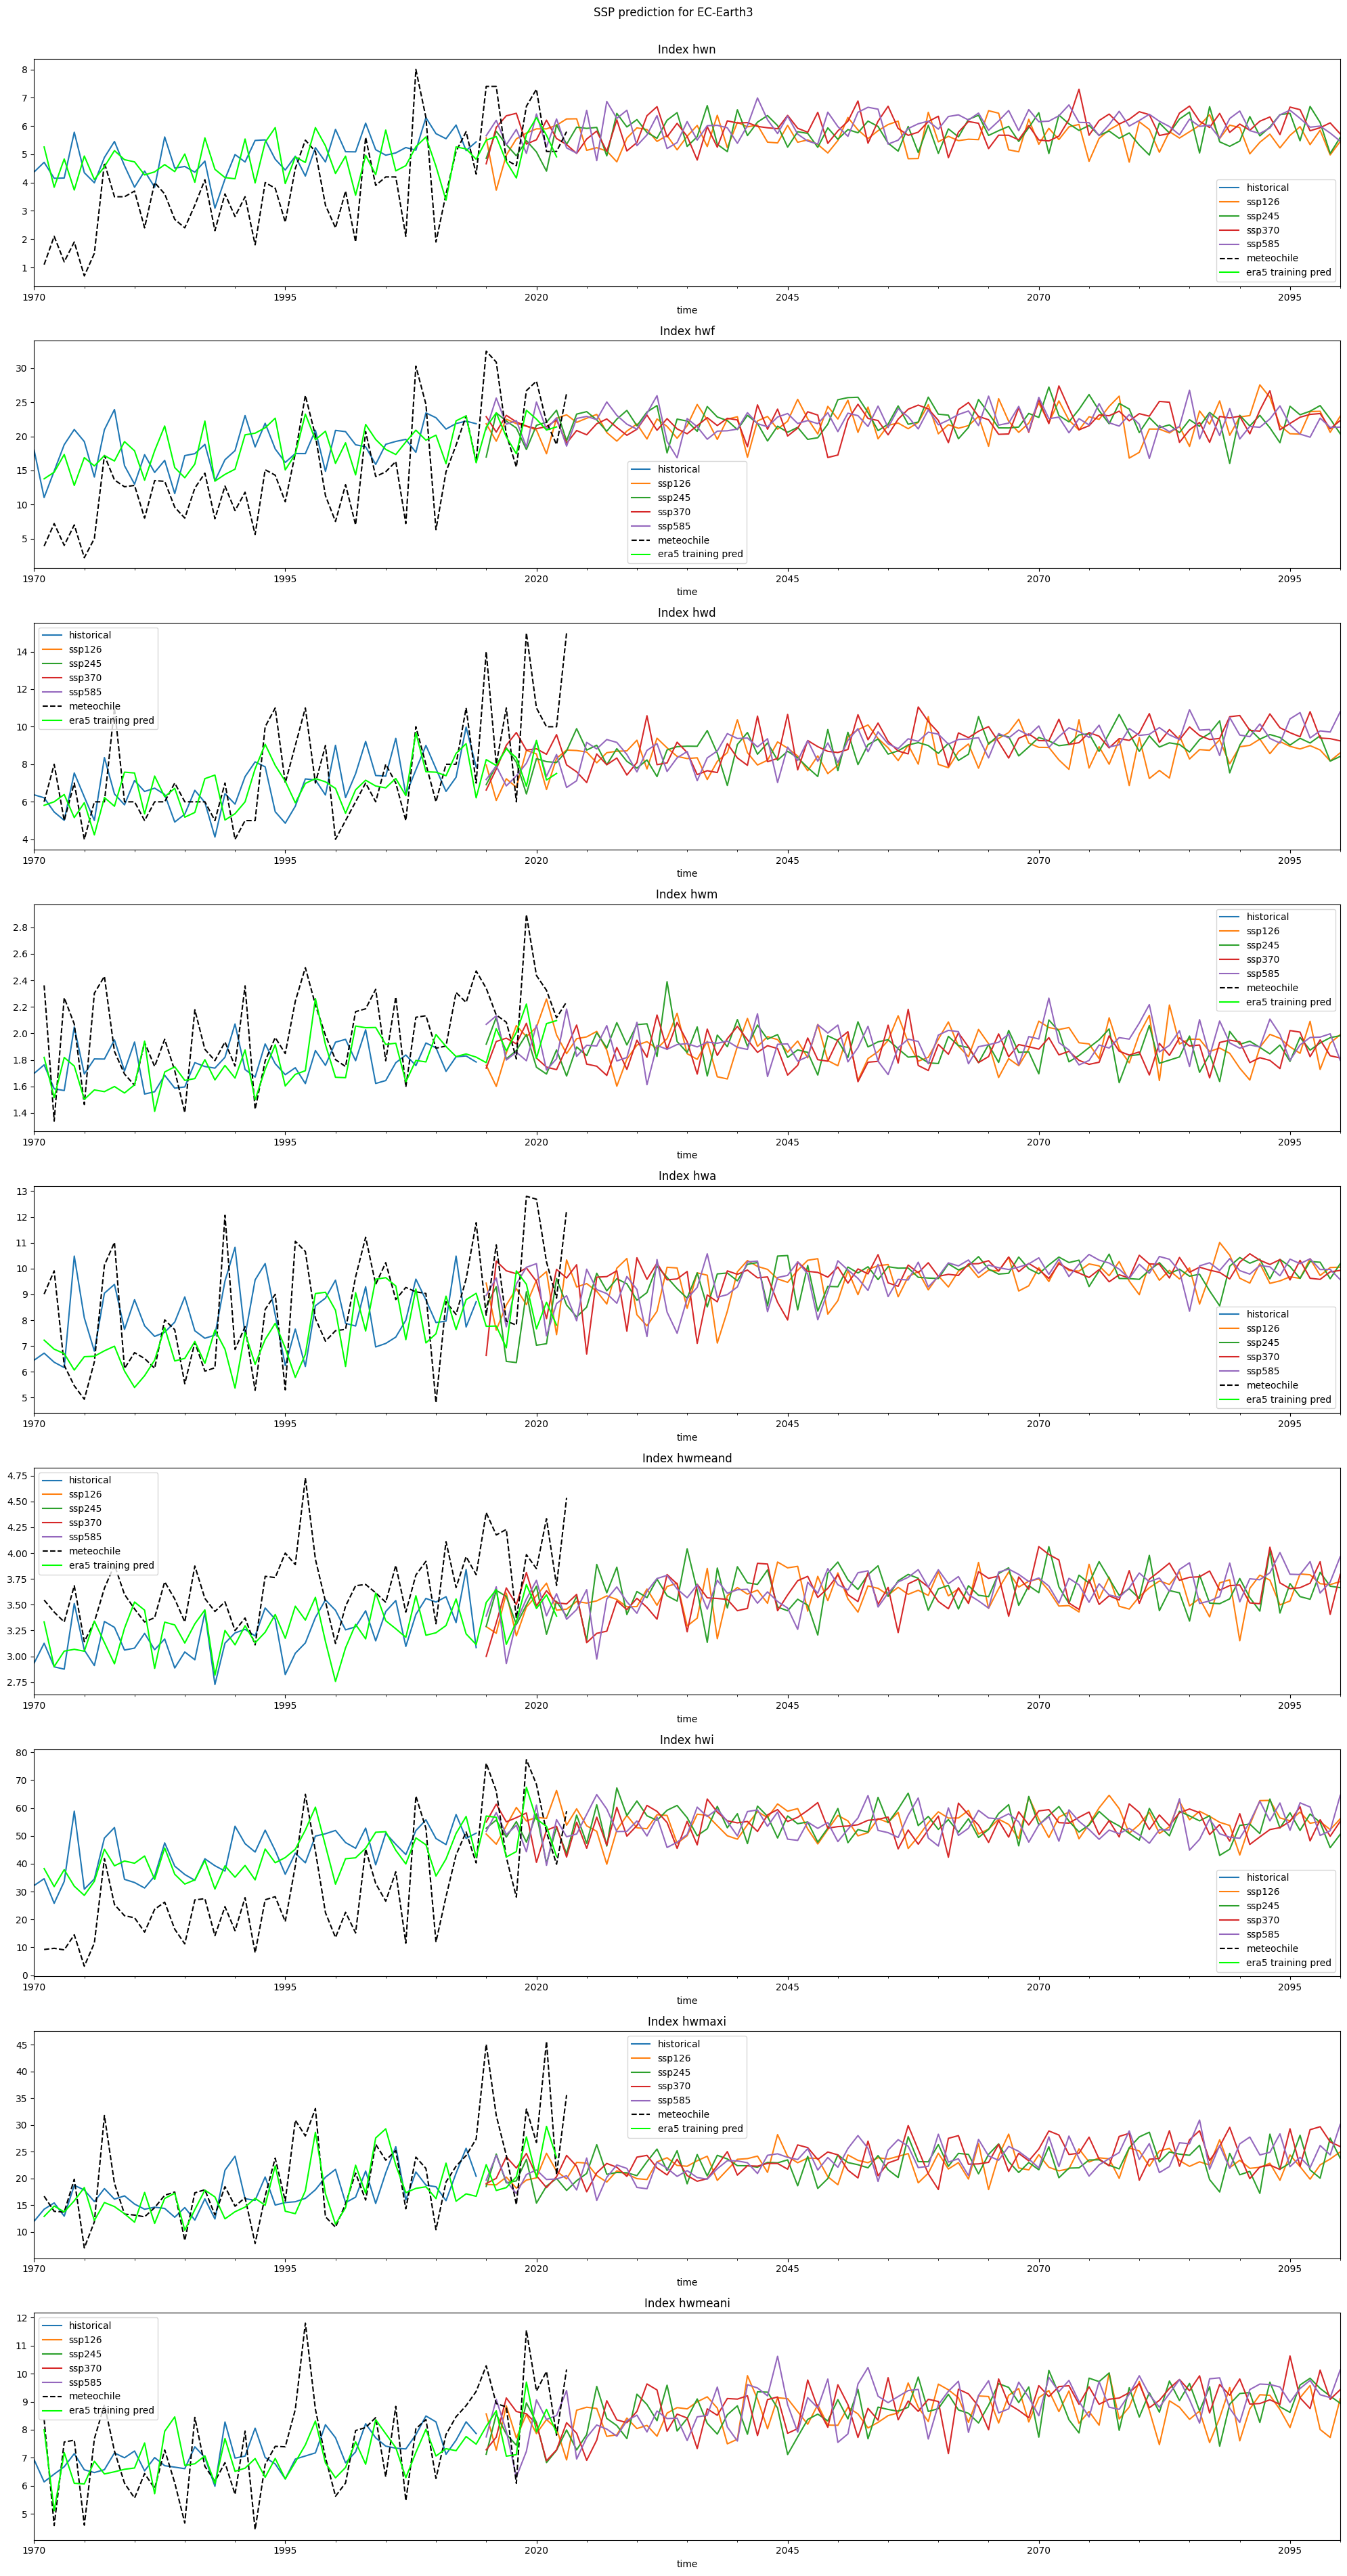

In [34]:
model = "EC-Earth3"
scenarios_prediction = models_predicted_yearly[model]
fig, axs = plt.subplots(len(indices_of_interest), figsize=(20, 40))
for i, index in enumerate(indices_of_interest):
    for scenario, df in scenarios_prediction.items():
        df.plot(y=index, ax=axs[i], label=scenario)
    meteochile_yearly.plot(y=index, linestyle="--", label="meteochile", ax=axs[i], c="black")
    pred_train_yearly.plot(y=index, label="era5 training pred", ax=axs[i], c="lime")
    axs[i].set_title(f"Index {index}")
fig.tight_layout(rect=[0, 0.03, 1, 0.97]) 
fig.suptitle(f"SSP prediction for {model}")
plt.show()

# By labels

### hwf, hwm, hwi

In [35]:
indices_of_interest = ["hwf", "hwm", "hwi"]
hws_labels = hws_chile[indices_of_interest]
era5_df = pd.concat((historical_dfs["ERA5"],hws_labels),axis=1)

In [36]:
meteochile_yearly = transform_time_label(era5_df[indices_of_interest], "year")

In [39]:
bounds = (-1.1692892810242344, -0.30647585455315646, 3.0, 6.499969486244418)
loss_fn=SERA(bounds=bounds,T=100, initial_weight=0.1, fn="piecewise2")
models_scenario_predicted = {model: {} for model in cmip6_drivers_dfs.keys()}
df_pred_train = pd.DataFrame(columns=indices_of_interest, index=era5_df.index)

for i in range(1,13):
    df_season = era5_df[era5_df.index.month==i]
    cnn_rnn_model = Sequential([
            Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(era5_df.columns) - len(indices_of_interest))),
            Reshape((1, 16)),  # Back to time dimension
            SimpleRNN(8, activation="tanh"),
            Dropout(0.1),
            Dense(len(indices_of_interest))
        ])
    pred = PredictionModel(df_season, i, indices_of_interest, cnn_rnn_model, name_regressor="CNNRNN16",loss_fn=loss_fn)
    pred.compile_keras_model()
    
    y_train, y_pred_train = pred.train(len_pred)
    df_pred_train.loc[df_season.index[:-len_pred]] = pred.label_scaler.inverse_transform(y_pred_train)
    df_pred_train.sort_index(inplace=True)
    for name, scenarios_df in cmip6_drivers_dfs.items():
        for scenario in scenarios:
            if i==1:
                models_scenario_predicted[name][scenario] = pd.DataFrame()
            df_target = scenarios_df[scenario][scenarios_df[scenario].index.month==i]
            if scenario == "historical":
                df_target = df_target[(df_target.index.year >=1970) & (df_target.index.year <= 2014)]
            else:
                df_target = df_target[(df_target.index.year >=2015) & (df_target.index.year <= 2100)]
            # df_target[indices_of_interest] = df_season[indices_of_interest]
            # Normalize cmip6 features for machine input
            target = pred.scaler_X.transform(df_target[pred.scaler_X.feature_names_in_])
            # Reshape for keras and predict
            predicted_normalized = pred.regressor.predict(pred.reshape_for_keras(target))
            # Transform back to original range
            predicted_real = pred.label_scaler.inverse_transform(predicted_normalized)
            predicted = pd.DataFrame(predicted_real).rename(columns={i: label for i,label in enumerate(indices_of_interest)})
            predicted["Date"] = df_target.index
            predicted.set_index("Date",inplace=True)
            models_scenario_predicted[name][scenario] = pd.concat((models_scenario_predicted[name][scenario],predicted),axis=0)
        
df_pred_train = df_pred_train.dropna()
df_pred_train = df_pred_train.astype(np.number)


3/3 [==============================] - 0s 1ms/step


c:\Users\marti\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\common.py:1687: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)


In [41]:
mean_scenario = {}
mean_std_scenario = {}
for scenario in scenarios:
    temp_df = pd.DataFrame()
    for name, model_scenario in models_scenario_predicted.items():
        temp_df = pd.concat((temp_df, model_scenario[scenario]), axis=1)
        
    mean_scenario[scenario] = pd.DataFrame(columns=models_scenario_predicted["EC-Earth3"][scenario].columns,index=model_scenario[scenario].index)
    mean_std_scenario[scenario] = pd.DataFrame(columns=models_scenario_predicted["EC-Earth3"][scenario].columns,index=model_scenario[scenario].index)

    for col in np.unique(temp_df.columns):
        mean_scenario[scenario][col] = temp_df[col].mean(axis=1)
        mean_std_scenario[scenario][col] = temp_df[col].std(axis=1)
models_scenario_predicted["mean_monthly"] = mean_scenario
## Build yearly and decadal indices
for scenario in scenarios:
    models_scenario_predicted["mean_monthly"][scenario] = models_scenario_predicted["mean_monthly"][scenario].astype(np.float64)
models_predicted_yearly = {model: {} for model in models_scenario_predicted.keys()}
models_predicted_decadal = {model: {} for model in models_scenario_predicted.keys()}

for name, model_scenario in models_scenario_predicted.items():
    for scenario, df in model_scenario.items():
        
        models_predicted_yearly[name][scenario] = transform_time_label(df, "year")
        models_predicted_decadal[name][scenario] = transform_time_label(df, "decade")

pred_train_yearly = transform_time_label(df_pred_train, "year")
mean_yearly_scenario = {}
min_yearly_scenario = {}
max_yearly_scenario = {}
mean_yearly_std_scenario = {}

features = models_predicted_yearly["EC-Earth3"][scenario].columns

for scenario in scenarios:
    temp_df = pd.DataFrame()
    for name, model_scenario in models_predicted_yearly.items():
        if "mean" not in name:
            temp_df = pd.concat((temp_df, model_scenario[scenario]), axis=1)
    
    yearly_dates = model_scenario[scenario].index
    mean_yearly_scenario[scenario] = pd.DataFrame(columns=features,index=yearly_dates)
    min_yearly_scenario[scenario] = pd.DataFrame(columns=features,index=yearly_dates)
    max_yearly_scenario[scenario] = pd.DataFrame(columns=features,index=yearly_dates)
    mean_yearly_std_scenario[scenario] = pd.DataFrame(columns=features,index=yearly_dates)
    for col in np.unique(temp_df.columns):
        mean_yearly_scenario[scenario][col] = temp_df[col].mean(axis=1)
        min_yearly_scenario[scenario][col] = temp_df[col].min(axis=1)
        max_yearly_scenario[scenario][col] = temp_df[col].max(axis=1)
        mean_yearly_std_scenario[scenario][col] = temp_df[col].std(axis=1)
models_predicted_yearly["yearly_then_mean"] = mean_yearly_scenario
models_predicted_yearly["yearly_then_min"] = min_yearly_scenario
models_predicted_yearly["yearly_then_max"] = max_yearly_scenario



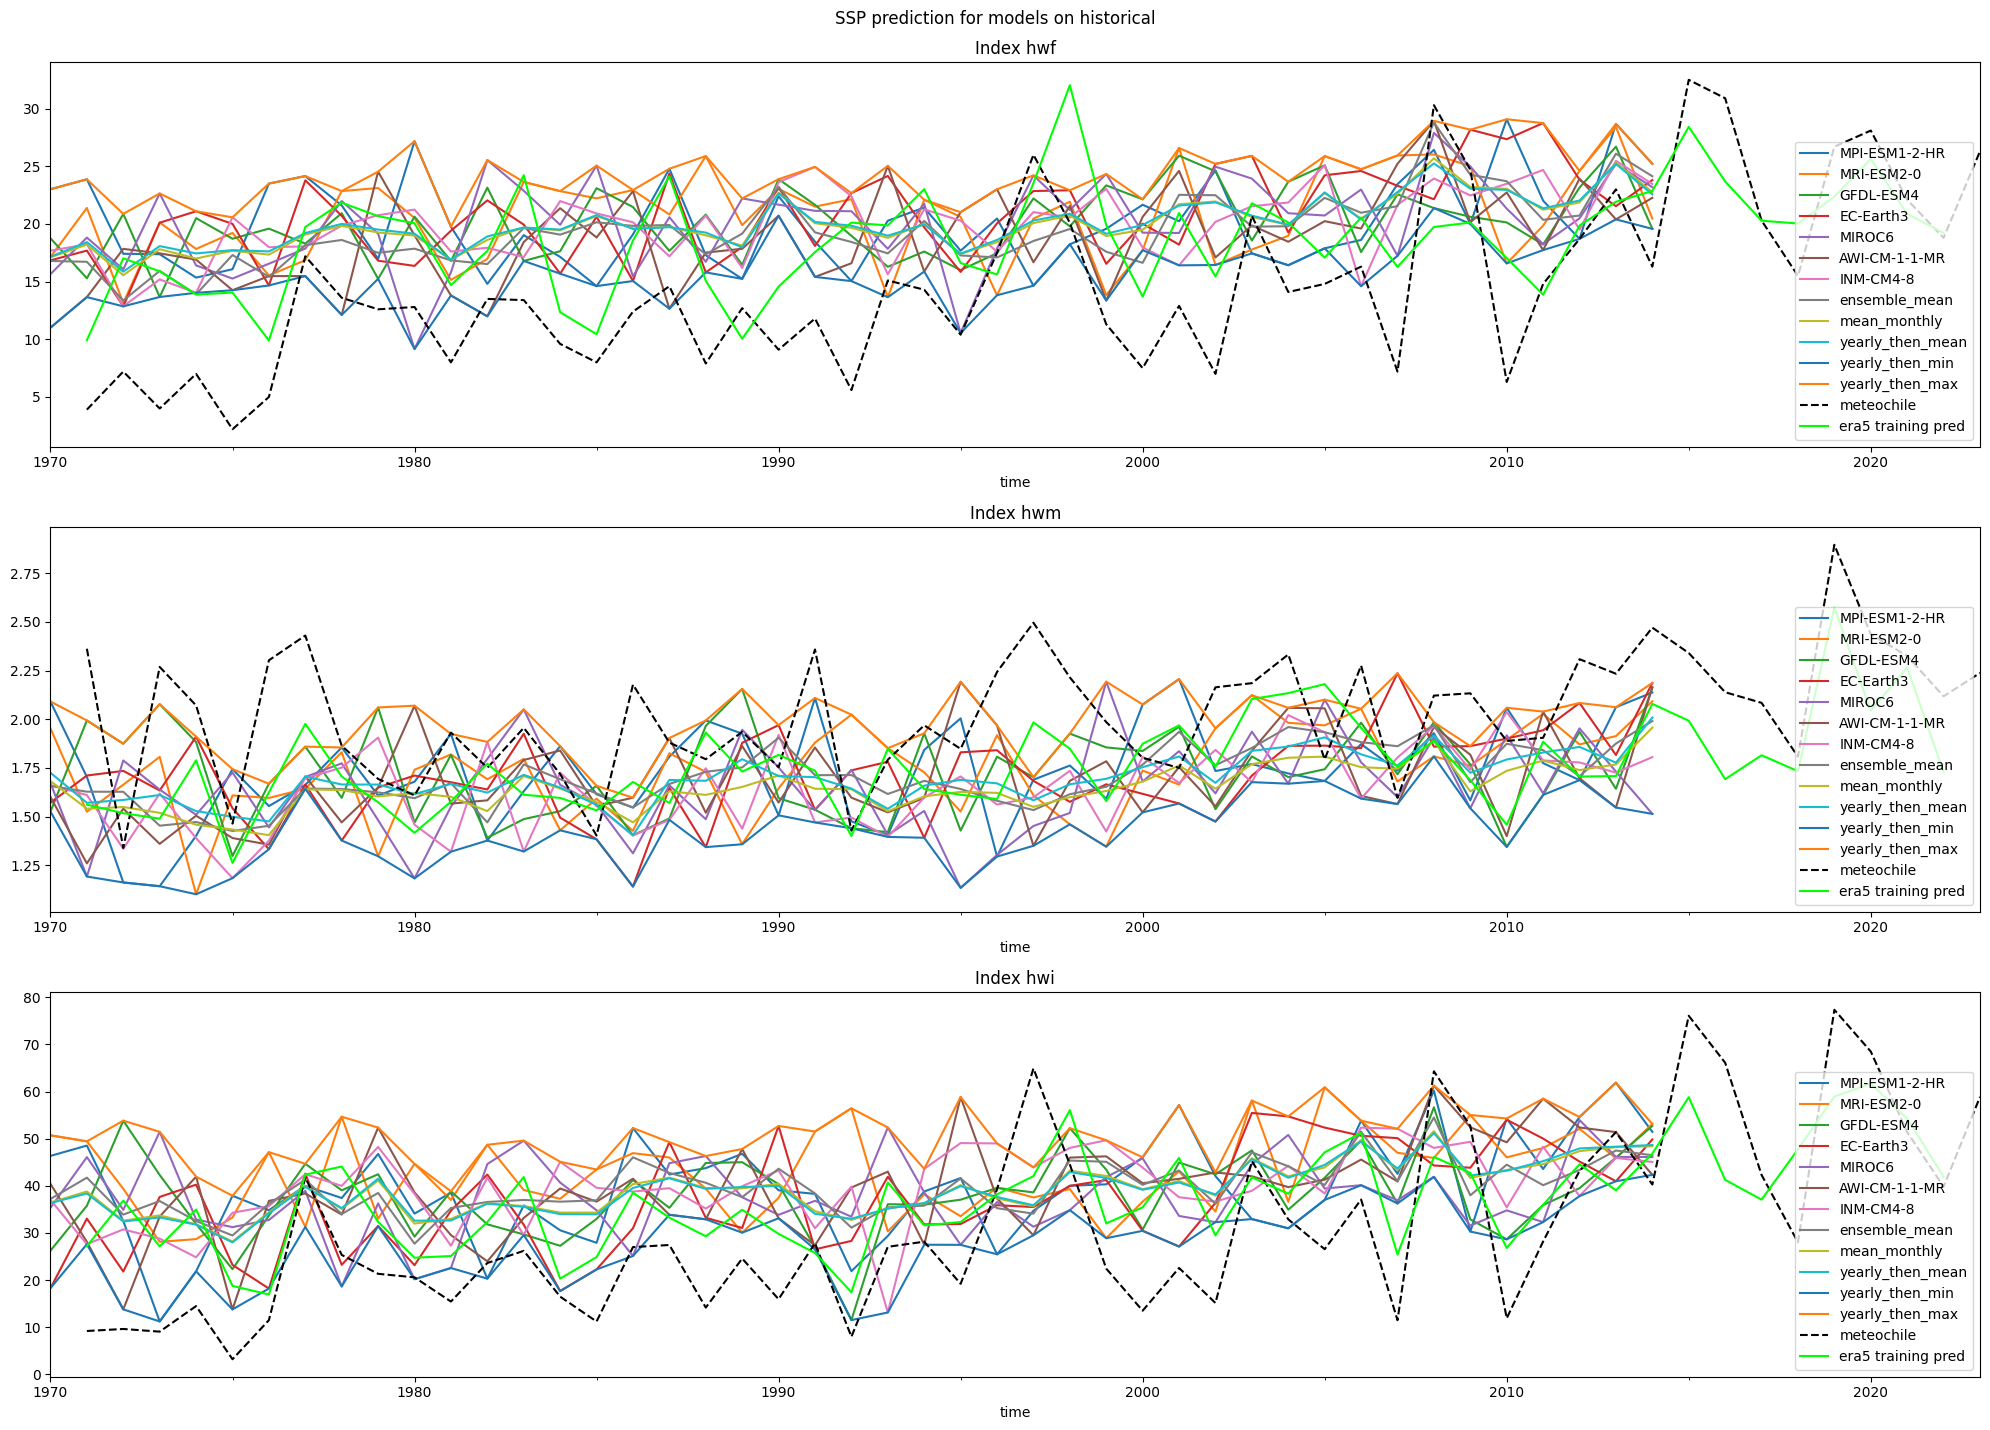

In [47]:
## Prediction of models on historical
meteochile_yearly = transform_time_label(era5_df[indices_of_interest], "year")
scenario = "historical"
fig, axs = plt.subplots(len(indices_of_interest), figsize=(20, 15))
for i, index in enumerate(indices_of_interest):
    for model, scenarios_pred in models_predicted_yearly.items():
        scenarios_pred[scenario].plot(y=index, ax=axs[i], label=model)
    meteochile_yearly.plot(y=index, linestyle="--", label="meteochile", ax=axs[i], c="black")
    pred_train_yearly.plot(y=index, label="era5 training pred", ax=axs[i], c="lime")
    axs[i].set_title(f"Index {index}")
fig.tight_layout(rect=[0, 0.03, 1, 0.97]) 
fig.suptitle(f"SSP prediction for models on historical")
plt.show()

In [44]:
meteochile_values = meteochile_yearly[meteochile_yearly.index.year <= 2014]
df_mae = pd.DataFrame(columns=meteochile_values.columns, index=list(models_predicted_yearly.keys()))
df_mape = pd.DataFrame(columns=meteochile_values.columns, index=list(models_predicted_yearly.keys()))
df_mse = pd.DataFrame(columns=meteochile_values.columns, index=list(models_predicted_yearly.keys()))
for name, scenario_dict in models_predicted_yearly.items():
    model_values =  scenario_dict["historical"]
    model_values = model_values[model_values.index.year >= 1971]
    df_mae.loc[name] = mean_absolute_error(meteochile_values, model_values, multioutput="raw_values")
    df_mape.loc[name] = mean_absolute_percentage_error(meteochile_values, model_values, multioutput="raw_values")
    df_mse.loc[name] = mean_squared_error(meteochile_values, model_values, multioutput="raw_values")


In [46]:
df_mae

hwf       hwm        hwi
MPI-ESM1-2-HR      8.470159  0.349783    17.5964
MRI-ESM2-0         8.729029  0.333322  19.429039
GFDL-ESM4          8.223013  0.336433  15.127719
EC-Earth3            8.6716  0.351837  14.835646
MIROC6             7.832831  0.420432  16.706747
AWI-CM-1-1-MR      7.326674  0.375484  15.703527
INM-CM4-8          7.965162  0.390391  17.023525
ensemble_mean      7.209047   0.34167  16.508068
mean_monthly       7.837427  0.366189   16.01316
yearly_then_mean   7.934208  0.327399  15.947905
yearly_then_min    5.110396  0.560518    9.55114
yearly_then_max   11.738798  0.275958  25.806882

In [45]:
df_mape["mean"] = df_mape.mean(axis=1)
df_mape

hwf       hwm       hwi      mean
MPI-ESM1-2-HR     1.126928  0.168071  1.208804  0.834601
MRI-ESM2-0        1.154452  0.163092  1.376113  0.897886
GFDL-ESM4         1.096581  0.166273  1.035741  0.766199
EC-Earth3         1.151149   0.17055  0.989723  0.770474
MIROC6            1.064197  0.202184  1.185311   0.81723
AWI-CM-1-1-MR      0.95326  0.179585  1.031821  0.721555
INM-CM4-8         1.093709  0.185257  1.210679  0.829882
ensemble_mean     0.981413  0.162938  1.178537  0.774296
mean_monthly      1.065676  0.172791  1.135638  0.791368
yearly_then_mean   1.07808  0.154384  1.129632  0.787365
yearly_then_min   0.704023  0.269161  0.542312  0.505166
yearly_then_max   1.501671  0.144363  1.782606   1.14288

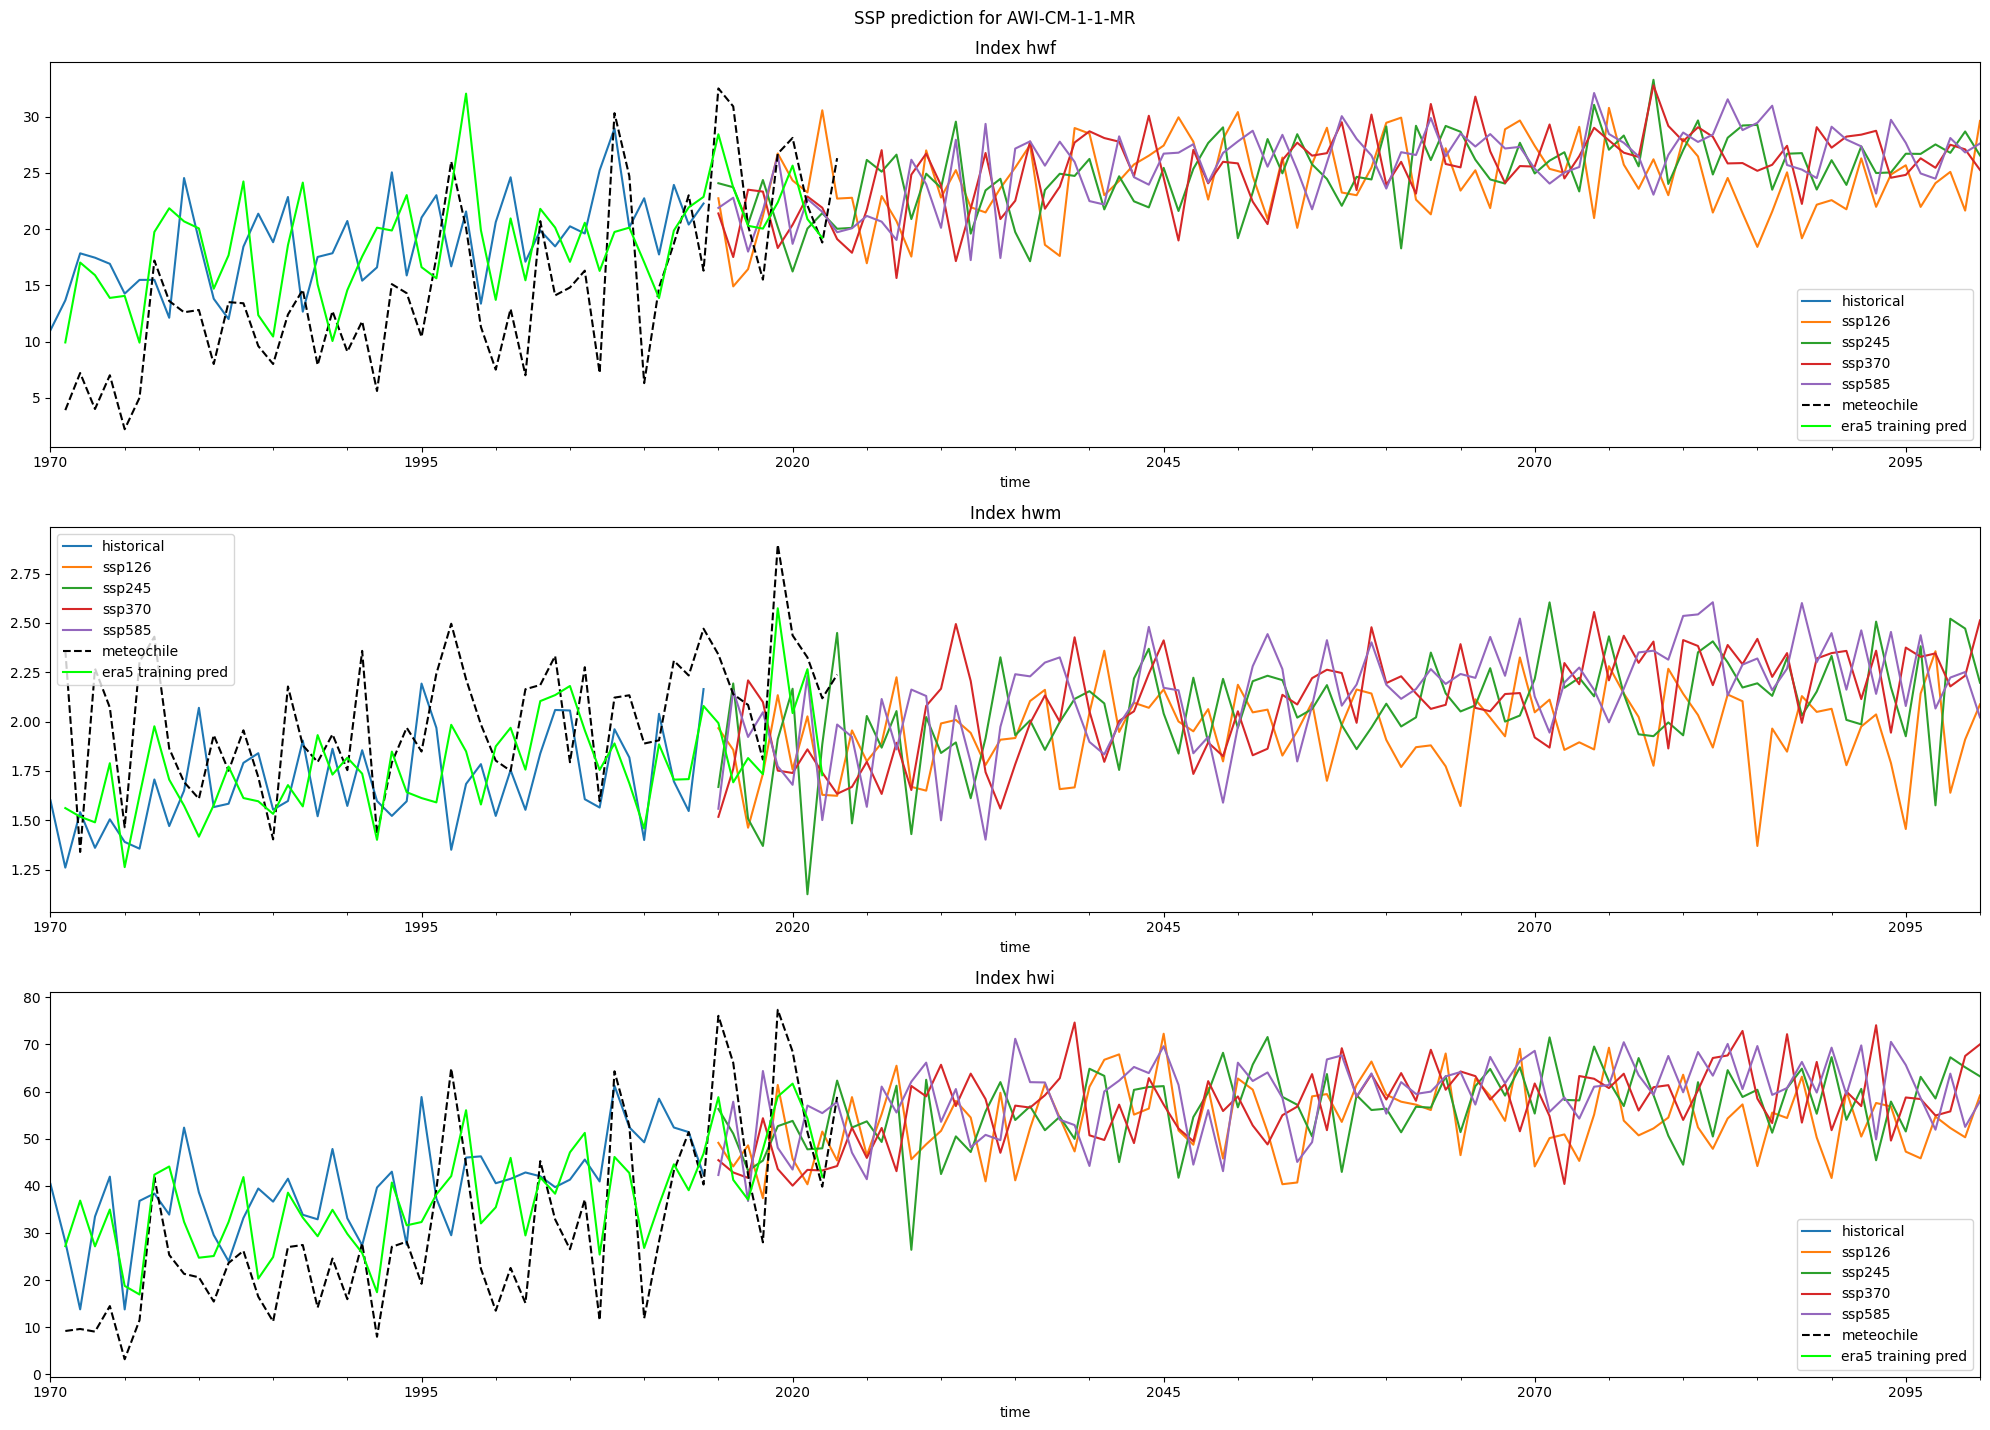

In [49]:
model = "AWI-CM-1-1-MR"
scenarios_prediction = models_predicted_yearly[model]
fig, axs = plt.subplots(len(indices_of_interest), figsize=(20, 15))
for i, index in enumerate(indices_of_interest):
    for scenario, df in scenarios_prediction.items():
        df.plot(y=index, ax=axs[i], label=scenario)
    meteochile_yearly.plot(y=index, linestyle="--", label="meteochile", ax=axs[i], c="black")
    pred_train_yearly.plot(y=index, label="era5 training pred", ax=axs[i], c="lime")
    axs[i].set_title(f"Index {index}")
fig.tight_layout(rect=[0, 0.03, 1, 0.97]) 
fig.suptitle(f"SSP prediction for {model}")
plt.show()

### Representative on ssp585

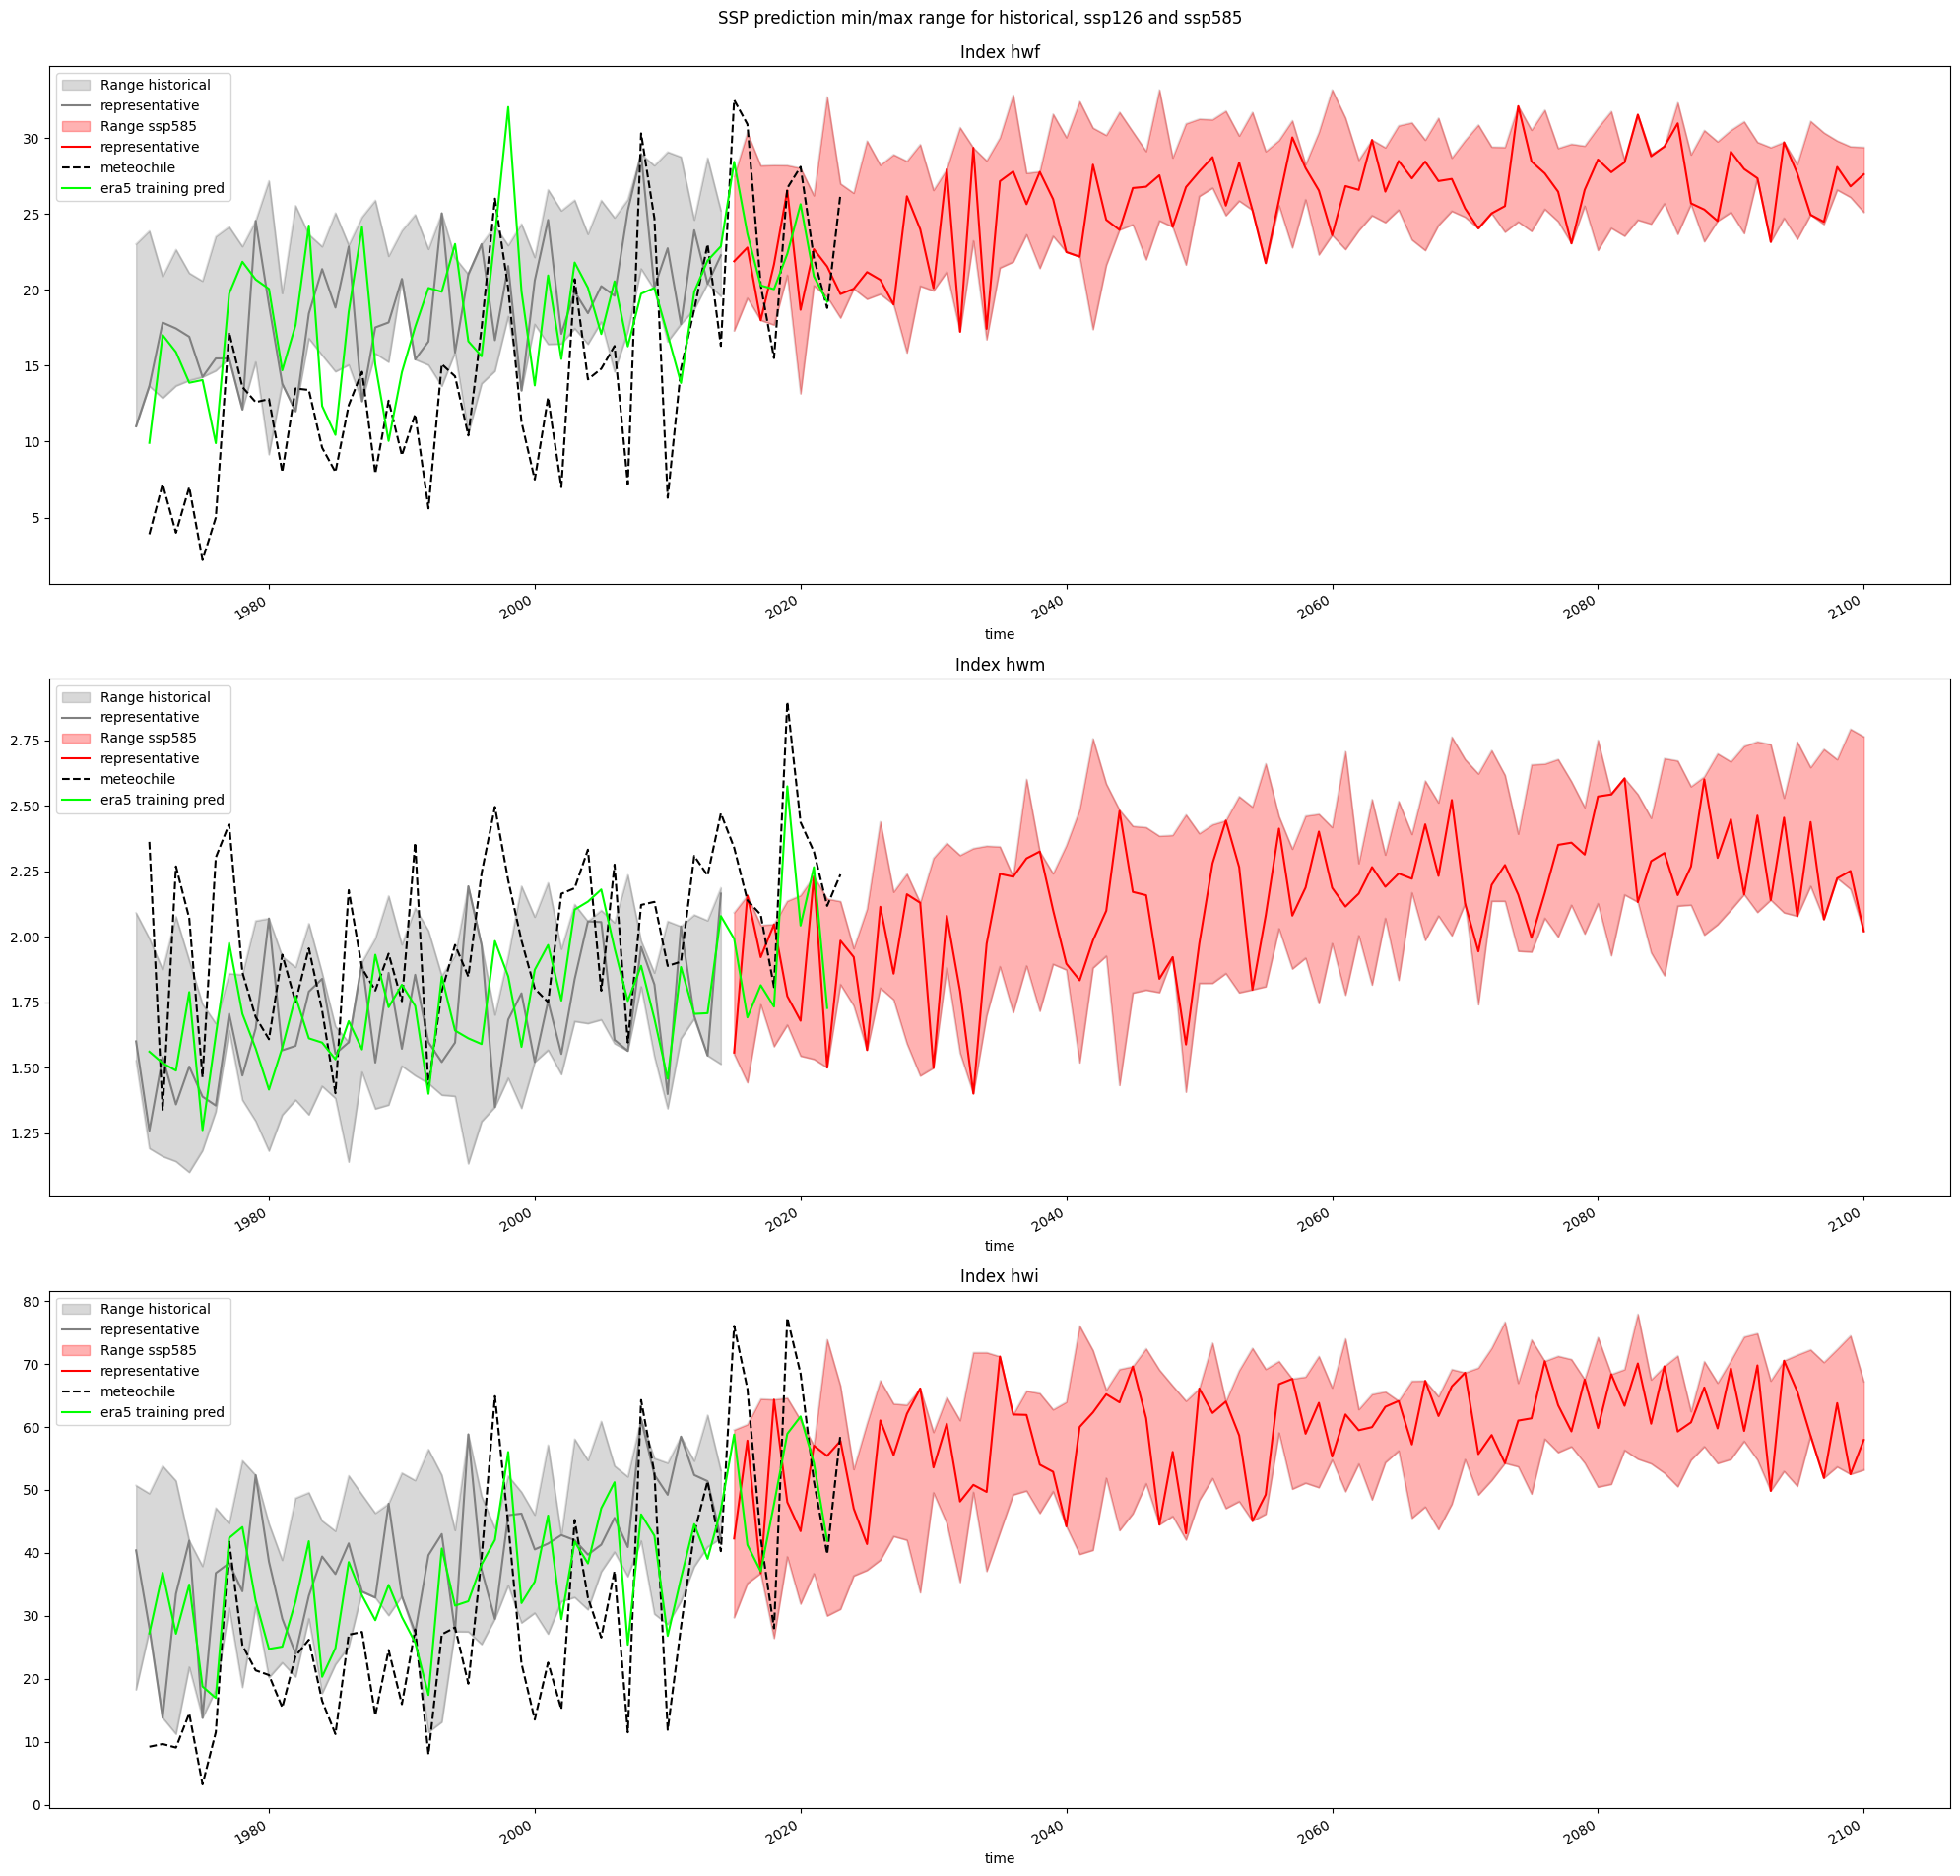

In [54]:
scenarios_prediction_min = models_predicted_yearly["yearly_then_min"]
scenarios_prediction_max = models_predicted_yearly["yearly_then_max"]
colors = {
    "historical": "gray",
    "ssp126": "blue",
    "ssp585": "red"
}
model = "AWI-CM-1-1-MR"
scenarios_prediction = models_predicted_yearly[model]

fig, axs = plt.subplots(len(indices_of_interest), figsize=(20, 20))
for i, index in enumerate(indices_of_interest):
    for scenario in ("historical", "ssp585"):
        color=colors[scenario]
        df_min = scenarios_prediction_min[scenario]
        df_max = scenarios_prediction_max[scenario]
        axs[i].plot(
            df_min.index, df_min[index].values, color="black",alpha=0.1
        )
        axs[i].plot(
            df_min.index, df_max[index].values, color="black",alpha=0.1
        )
        axs[i].fill_between(
            df_min.index, df_min[index].values, df_max[index].values, alpha=0.3, color=color, label=f"Range {scenario}"
        )

        df_representative = scenarios_prediction[scenario]
        axs[i].plot(
            df_representative.index, df_representative[index].values, color=colors[scenario], label=f"representative"
        )
    meteochile_yearly.plot(y=index, linestyle="--", label="meteochile", ax=axs[i], c="black")
    pred_train_yearly.plot(y=index, label="era5 training pred", ax=axs[i], c="lime")
    axs[i].set_title(f"Index {index}")
    axs[i].legend()
fig.tight_layout(rect=[0, 0.03, 1, 0.97]) 
fig.suptitle(f"SSP prediction min/max range for historical, ssp126 and ssp585")
plt.show()